In [2]:
import pandas as pd
import numpy as np
import timeit
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
#import plotly.graph_objs as go
%matplotlib inline

In [3]:
from pandas_datareader import data as pdr

/Users/reejungkim/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [4]:
date_end = dt.datetime.today()
date_start = date_end - dt.timedelta(100)

## Web scraping S&P100 companies from Wikipedia table

In [5]:
import requests
website_url = requests.get("https://en.wikipedia.org/wiki/S%26P_100").text

from bs4 import BeautifulSoup
soup = BeautifulSoup(website_url,'lxml')
#print(soup.prettify())

In [6]:
wiki_table = soup.find('table',{'class':'wikitable sortable'})

wiki_table_data = wiki_table.tbody.find_all("tr")


# Get all the headings of Lists
headings = []
for th in wiki_table_data[0].find_all("th"):
    # remove any newlines and extra spaces from left and right
    headings.append(th.text.replace('\n', ' ').strip())

print(headings)


In [7]:
data = []
tHeader = []
SP100_tickers = pd.DataFrame()

for tr in wiki_table.find_all("tr"):
    for th in tr.find_all("th")[:1]:
        tHeader = th.get_text(strip=True)
        SP100_tickers[tHeader] = []
    for td in tr.find_all("td")[:1]:
        data.append( td.get_text(strip=True))
        
SP100_tickers[tHeader] = data

In [8]:
SP100_tickers

,Symbol
0,AAPL
1,ABBV
2,ABT
3,ACN
4,ADBE
...,...
96,VZ
97,WBA
98,WFC
99,WMT


# Use DataReader to get financial data of S&P100 companies from yahoo

In [38]:
%%time

df = pd.DataFrame()


for i in data:
    symbol = SP100_tickers.loc[SP100_tickers['Symbol']==i]
    try:
        symbol_data = pdr.DataReader(i, 'yahoo', date_start, date_end).reset_index()
        #display(symbol_data)  
    except: 
        print(i + " - Err")
        symbol_data = pd.DataFrame()
        pass
    single_table = pd.concat([symbol, symbol_data], axis=0, ignore_index=False)
    single_table['Symbol'].ffill(inplace=True)
    df = df.append(single_table)
    

BRK.B - Err
CPU times: user 9.52 s, sys: 731 ms, total: 10.2 s
Wall time: 1min 8s


In [39]:
df = df.loc[df['Date'].notnull()]

In [41]:
df

,Symbol,Date,High,Low,Open,Close,Volume,Adj Close
0,AAPL,2020-05-26,324.239990,316.500000,323.500000,316.730011,31380500.0,316.730011
1,AAPL,2020-05-27,318.709991,313.089996,316.140015,318.109985,28236300.0,318.109985
2,AAPL,2020-05-28,323.440002,315.630005,316.769989,318.250000,33390200.0,318.250000
3,AAPL,2020-05-29,321.149994,316.470001,319.250000,317.940002,38399500.0,317.940002
4,AAPL,2020-06-01,322.350006,317.209991,317.750000,321.850006,20197800.0,321.850006
...,...,...,...,...,...,...,...,...
17,AAPL,2020-06-18,47.330002,45.770000,46.110001,46.919998,21478700.0,46.919998
18,AAPL,2020-06-19,48.259998,45.980000,48.220001,45.980000,48899900.0,45.980000
19,AAPL,2020-06-22,46.439999,45.400002,45.689999,46.419998,17565400.0,46.419998
20,AAPL,2020-06-23,47.220001,46.500000,46.900002,46.700001,18911200.0,46.700001


df = df.reset_index(drop=True)

df.groupby(['Symbol']).describe().transpose()

df_Org = df

# Forecasting closing prices using Tensorflow

In [42]:
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
le = preprocessing.LabelEncoder()

In [43]:
df.columns

Index(['Symbol', 'Date', 'High', 'Low', 'Open', 'Close', 'Volume',
       'Adj Close'],
      dtype='object')

In [44]:
df['Date encoded'] = le.fit_transform(df['Date'])

In [45]:
df = df.loc[df['Symbol']=='AAPL']

In [46]:
df.shape

(2200, 9)

In [58]:
df.columns

Index(['Symbol', 'Date', 'High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close',
       'Date encoded'],
      dtype='object')

In [61]:
df

,Symbol,Date,High,Low,Open,Close,Volume,Adj Close,Date encoded
0,AAPL,2020-05-26,324.239990,316.500000,323.500000,316.730011,31380500.0,316.730011,0
1,AAPL,2020-05-27,318.709991,313.089996,316.140015,318.109985,28236300.0,318.109985,1
2,AAPL,2020-05-28,323.440002,315.630005,316.769989,318.250000,33390200.0,318.250000,2
3,AAPL,2020-05-29,321.149994,316.470001,319.250000,317.940002,38399500.0,317.940002,3
4,AAPL,2020-06-01,322.350006,317.209991,317.750000,321.850006,20197800.0,321.850006,4
...,...,...,...,...,...,...,...,...,...
17,AAPL,2020-06-18,47.330002,45.770000,46.110001,46.919998,21478700.0,46.919998,17
18,AAPL,2020-06-19,48.259998,45.980000,48.220001,45.980000,48899900.0,45.980000,18
19,AAPL,2020-06-22,46.439999,45.400002,45.689999,46.419998,17565400.0,46.419998,19
20,AAPL,2020-06-23,47.220001,46.500000,46.900002,46.700001,18911200.0,46.700001,20


In [62]:
df.values[:30, 8]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 0, 1, 2, 3, 4, 5, 6, 7], dtype=object)

In [63]:
df.values[10:, 8]

array([10, 11, 12, ..., 19, 20, 21], dtype=object)

In [64]:
x_train, y_train = df.values[:30, 2], df.values[:30, 8]
x_test, y_test = df.values[30:, 2], df.values[30:, 8]

In [65]:
x_train

array([324.239990234375, 318.7099914550781, 323.44000244140625,
       321.1499938964844, 322.3500061035156, 323.44000244140625,
       326.20001220703125, 325.6199951171875, 331.75, 333.6000061035156,
       345.6099853515625, 354.7699890136719, 351.05999755859375,
       347.79998779296875, 345.67999267578125, 353.20001220703125,
       355.3999938964844, 353.45001220703125, 356.55999755859375,
       359.4599914550781, 372.3800048828125, 368.7699890136719,
       93.56999969482422, 91.0, 91.19000244140625, 92.88999938964844,
       93.05999755859375, 91.69999694824219, 91.5, 93.4800033569336],
      dtype=object)

In [67]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((30,), (30,), (2170,), (2170,))

In [69]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()

model.add(Dense(16, activation='sigmoid', input_shape=(1,)))
model.add(Dense(1, activation='linear'))

model.summary()

model.compile(optimizer='sgd', loss='mse', metrics=['mape']) 
#sgd - stochastic gradient descent
#mse - mean square error
#mape - mean absolute percentage error

from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=.2)

history = model.fit(x_train, y_train, batch_size=4, epochs=10, validation_data=(x_valid, y_valid))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 16)                32        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 49
Trainable params: 49
Non-trainable params: 0
_________________________________________________________________
Train on 19 samples, validate on 5 samples
Epoch 1/10
19/19 [==============================] - 0s 18ms/step - loss: 75.2700 - mape: 352821632.0000 - val_loss: 67.4659 - val_mape: 47.5957
Epoch 2/10
19/19 [==============================] - 0s 519us/step - loss: 50.9714 - mape: 591119552.0000 - val_loss: 48.8366 - val_mape: 42.5241
Epoch 3/10
19/19 [==============================] - 0s 645us/step - loss: 47.0344 - mape: 674987200.0000 - val_loss: 48.7601 - val_mape: 42.3880
Epoch 4/10
19/19 [=========================

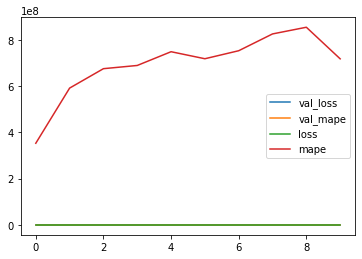

In [70]:
for name, value in history.history.items():
    plt.plot(value, label=name)
plt.legend()
plt.show()

In [71]:
## evaluate model

results = model.evaluate(x_test, y_test)

print('Loss: {:.6f} - MAPE: {:.6f}'.format(*results))

2170/2170 [==============================] - 0s 29us/step
Loss: 48.326719 - MAPE: 346513248.000000


In [72]:
test_pred = model.predict(x_test)

test_pred = np.squeeze(test_pred)

test_pred

array([7.679962 , 7.679966 , 7.6799545, ..., 7.6867437, 7.6863146,
       7.6870193], dtype=float32)

In [73]:
test_pred = model.predict(x_test)

test_pred = np.squeeze(test_pred)

test_pred

array([7.679962 , 7.679966 , 7.6799545, ..., 7.6867437, 7.6863146,
       7.6870193], dtype=float32)

In [74]:
y_test

array([8, 9, 10, ..., 19, 20, 21], dtype=object)

In [75]:
for pred, true in zip(test_pred, y_test):
    print('Pred: {:.6f} - True: {:.6f}'.format(pred,true))

Pred: 7.679962 - True: 8.000000
Pred: 7.679966 - True: 9.000000
Pred: 7.679955 - True: 10.000000
Pred: 7.679941 - True: 11.000000
Pred: 7.679954 - True: 12.000000
Pred: 7.679968 - True: 13.000000
Pred: 7.679973 - True: 14.000000
Pred: 7.679957 - True: 15.000000
Pred: 7.679953 - True: 16.000000
Pred: 7.679956 - True: 17.000000
Pred: 7.679946 - True: 18.000000
Pred: 7.679952 - True: 19.000000
Pred: 7.679942 - True: 20.000000
Pred: 7.679953 - True: 21.000000
Pred: 7.679978 - True: 0.000000
Pred: 7.680002 - True: 1.000000
Pred: 7.679978 - True: 2.000000
Pred: 7.679962 - True: 3.000000
Pred: 7.679974 - True: 4.000000
Pred: 7.679979 - True: 5.000000
Pred: 7.679984 - True: 6.000000
Pred: 7.679996 - True: 7.000000
Pred: 7.680011 - True: 8.000000
Pred: 7.679985 - True: 9.000000
Pred: 7.679982 - True: 10.000000
Pred: 7.679983 - True: 11.000000
Pred: 7.679985 - True: 12.000000
Pred: 7.680009 - True: 13.000000
Pred: 7.680007 - True: 14.000000
Pred: 7.679992 - True: 15.000000
Pred: 7.679993 - True:

Pred: 7.682357 - True: 4.000000
Pred: 7.682375 - True: 5.000000
Pred: 7.682100 - True: 6.000000
Pred: 7.682238 - True: 7.000000
Pred: 7.681962 - True: 8.000000
Pred: 7.681878 - True: 9.000000
Pred: 7.682026 - True: 10.000000
Pred: 7.681913 - True: 11.000000
Pred: 7.682341 - True: 12.000000
Pred: 7.682512 - True: 13.000000
Pred: 7.682631 - True: 14.000000
Pred: 7.682377 - True: 15.000000
Pred: 7.682742 - True: 16.000000
Pred: 7.682826 - True: 17.000000
Pred: 7.682597 - True: 18.000000
Pred: 7.683214 - True: 19.000000
Pred: 7.683035 - True: 20.000000
Pred: 7.683781 - True: 21.000000
Pred: 7.682059 - True: 0.000000
Pred: 7.681418 - True: 1.000000
Pred: 7.681351 - True: 2.000000
Pred: 7.682088 - True: 3.000000
Pred: 7.681647 - True: 4.000000
Pred: 7.681257 - True: 5.000000
Pred: 7.680405 - True: 6.000000
Pred: 7.680274 - True: 7.000000
Pred: 7.679981 - True: 8.000000
Pred: 7.679962 - True: 9.000000
Pred: 7.680007 - True: 10.000000
Pred: 7.680041 - True: 11.000000
Pred: 7.680245 - True: 12.

Save model

In [77]:
model_path = 'model.h5'
model.save(model_path)

from keras.models import load_model

loaded_model = load_model(model_path)

In [78]:
loaded_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 16)                32        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 49
Trainable params: 49
Non-trainable params: 0
_________________________________________________________________


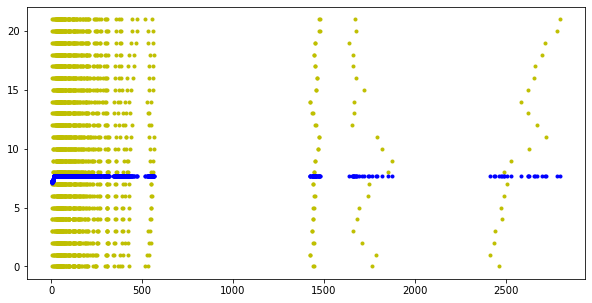

In [80]:
plt.figure(figsize=(10, 5))
plt.plot(x_test, y_test, '.y', x_test, test_pred, '.b')
plt.show()

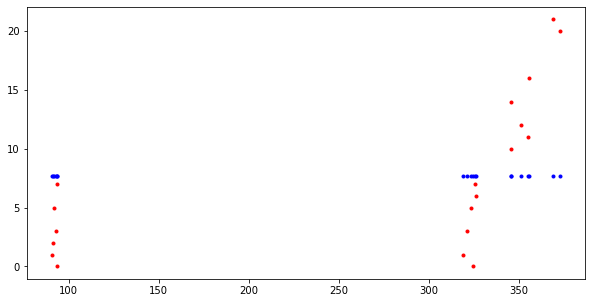

In [81]:
train_pred = model.predict(x_train)
train_pred = np.squeeze(train_pred)

plt.figure(figsize=(10, 5))
plt.plot(x_train, y_train, '.r', x_train, train_pred, '.b')
plt.show()